<a href="https://colab.research.google.com/github/jkoks-svg/ML_Project_ENSAE/blob/main/ML_Project_ENSAE_sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Inference Project: Impact of Scholarships on Student Success
---
**Main Research Questions:**
1. Does receiving a scholarship reduce the likelihood of dropping out within 3 years?
2. Does receiving a scholarship increase the likelihood of graduating within 3 years?

We apply **Double Machine Learning (DML)** and **Random Forests** to estimate causal effects using observational data from the UCI dataset _"Predict students dropout and academic success"_.

# Part 0 - Preprocessing

In [2]:
!pip install mlxtend
!pip install doubleml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.9/342.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


## Import Libraries

In [34]:
# Fundamental scientific computing libraries
import numpy as np  # Provides support for large, multi-dimensional arrays and matrices
import pandas as pd  # Used for data manipulation and analysis

# Double Machine Learning (DML) for causal inference
import doubleml as dml  # Implements DoubleML methods for causal machine learning

# Scikit-learn: Machine learning and preprocessing utilities
from sklearn.preprocessing import PolynomialFeatures  # Generates polynomial feature combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LogisticRegressionCV  # Lasso regression with cross-validation and logistic regression with cross-validation
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest models for classification and regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor  # Decision Tree models for classification and regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Standardizes features (scaling) and encodes categorical variables
from sklearn.pipeline import make_pipeline  # Simplifies workflow creation with preprocessing and model steps
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# XGBoost: Optimized gradient boosting library
from xgboost import XGBClassifier, XGBRegressor  # XGBoost models for classification and regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from mlxtend.regressor import StackingCVRegressor
import doubleml as dml
from joblib import Parallel, delayed

# Data visualization libraries
import matplotlib.pyplot as plt  # Standard plotting library
import seaborn as sns  # Enhances visualization capabilities with statistical plots
from IPython.display import display

from importlib import reload
# import declarations as d #Importing a custom module named 'declarations' as 'd'
# reload(d)

In [ ]:
#!pip install declarations

## Load and Import the Dataset

In [35]:
# Jort
# df=pd.read_csv(r"C:\Users\jortk\OneDrive\OneDrive Documenten\ENSAE\ENSAE ML for Econometrics\Project\data.csv", sep=";")

# Jakob
#df = pd.read_csv('data.csv', sep=';')

# Anushka
#from google.colab import drive
#drive.mount('/content/drive')
df=pd.read_csv("/content/drive/MyDrive/dropoutdata.csv", sep=";")

# Lucie
#import declarations as d #Importing a custom module named 'declarations' as 'd'
#reload(d)
#df=d.fetch_ucirepo(id=697)
#X=df.data.features
#y = df.data.targets
#df = pd.concat([X, y], axis=1)

df.head() # Display the first few rows of the dataset to get an overview

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Dataset Description:**
- target: Student status: Graduate, Dropout, or Enrolled
- Course: Study program the student is enrolled in
- Age at enrollment: Age of the student at the time of enrollment
- Gender: Binary indicator (0 = Male, 1 = Female)
- Scholarship holder: Binary indicator for receiving a scholarship (0 = No, 1 = Yes)
- Tuition fees up to date: Indicator if tuition fees are paid (0 = No, 1 = Yes)
- Debtor: Indicator if the student has outstanding debts (0 = No, 1 = Yes)
- Admission grade: Grade obtained at admission
- Previous qualification: Previous academic qualification of the student
- Previous qualification grade: Grade obtained in the previous qualification
- Displaced: Indicator if the student is displaced (0 = No, 1 = Yes)
- Educational special needs: Indicator for special education needs (0 = No, 1 = Yes)
- International: Indicator if the student is international (0 = No, 1 = Yes)
- Mother's qualification: Educational qualification of the student's mother
- Father's qualification: Educational qualification of the student's father
- Mother's occupation: Occupation of the student's mother
- Father's occupation: Occupation of the student's father
- Unemployment rate: Unemployment rate in the country during enrollment
- GDP growth rate: GDP growth rate at the time of enrollment
- Inflation rate: Inflation rate at the time of enrollment

## Other small edits

In [36]:
# Set notebook styling for better visuals
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

#Check for missig values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)

Missing values per column:
 Series([], dtype: int64)


### Note on Missig Data
The Series([], dtype: int64) indicates that the missing_values Series is empty. This means there are no missing values in any of the dataset columns. Thus, no missing value imputation is needed (e.g., filling with mean/median/mode or dropping rows) and the dataset is clean and ready for preprocessing or model training.
The data consists of 4424 observations and is supported by program SATDAP - Capacitação da Administração Pública under grant POCI-05-5762-FSE-000191, Portugal. We use Target as our outcome variable, Y, in our analysis.

# Part 1 - PICO Formulation

### **PICO Formulation for Analyzing the Impact of Scholarships and Gender on Student Dropout**  

#### **Population (P):**  
Undergraduate students enrolled in various programs (e.g. agronomy, design, education, etc.) at a Portuguese university​. The dataset contains 4,424 students with information on their demographics (age, gender, nationality), family background (parents’ education and occupation), socio-economic status (e.g. regional GDP, unemployment rate), and prior academic performance (high school grades, admission exam scores). All students began their degrees around the same time, and we observe their status 3 years after enrollment.

#### **Intervention (I):**  
Receiving a **scholarship** (binary treatment: 1 = scholarship holder, 0 = non-scholarship holder). Scholarships provide **financial aid**, which may help students remain enrolled and complete their degrees. In this dataset, about 24.8% of students received a scholarship. Scholarship assignment is not randomized – it may depend on merit and/or need, so treated and untreated students may differ in important ways (to be addressed by controlling for confounders).

#### **Comparison (C):**  
We compare **students who received a scholarship vs. those who did not**, while holding constant other factors. Key potential **confounders** include:

- **Academic preparation:** prior qualification grade, admission exam grade (students with better prior grades might both win scholarships and have lower dropout risk).
By controlling for these covariates, we attempt to isolate the effect of scholarships. We will also examine effect modification by gender, i.e., whether the scholarship’s impact differs for male vs. female students.
- **Socio-economic status:** whether the student is displaced (moved for studies), family’s education, regional economic indicators (unemployment, inflation, GDP) that might correlate with both scholarship allocation (often need-based) and dropout.
- **Demographics:** gender, age at enrollment, international student status, etc., which could influence scholarship decisions or educational outcomes.

#### **Outcome (O):**  
Student status 3 years after enrollment. The original outcome is categorical: Dropout, Enrolled (still studying), or Graduate (finished degree in 3 years). For causal analysis, we focus on two binary outcomes corresponding to our RQs:

- RQ1. (Dropout within 3 years): 1 if Dropout, 0 if still enrolled or graduated. This measures whether the student failed to persist (drop out) within the 3-year window.
- RQ2. (Graduation within 3 years): 1 if Graduated, 0 if not (i.e., still enrolled or dropped out by 3 years). This captures timely degree completion.

The central questions are whether scholarships causally decrease the dropout rate and increase the graduation rate within the standard time.

#### **Assumptions:**
We assume no unobserved confounding – i.e., given our covariates, scholarship status is as good as random (Ignorability). This requires that factors influencing both scholarship awards and student success (like academic merit and financial need) are adequately captured in our data. We also assume positivity (both scholarship and non-scholarship students exist at each combination of covariates) and SUTVA (one student’s treatment doesn’t directly affect another’s outcome). These are standard assumptions for causal inference​. Violation of these (for example, an unmeasured confounder like “intrinsic motivation” or teacher recommendations affecting both scholarship and success) could bias our results.

This PICO framework guides the analysis by helping us **quantify the causal effect of scholarships and gender on student success** while accounting for **potential confounders** using **Double Machine Learning (DML).**

# Part 2 - Exploratory data analysis (EDA): descriptive analysis, association and visualization

## Visualization of the Outcome (Target) Variable

<ipython-input-37-821a76d21eb6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


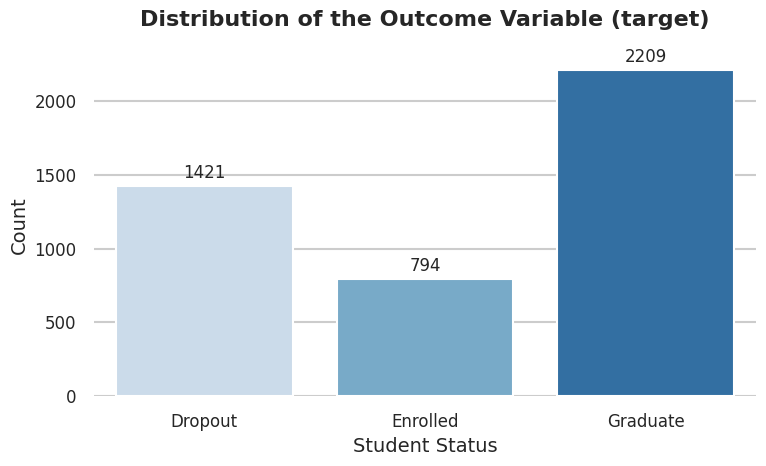

In [37]:
# Set basic style
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["font.family"] = "Alegreya Sans"

# Manually define three blue shades
blue_shades = sns.color_palette("Blues", 3)  # Light to dark blue

# Sort the categories if needed (optional but tidy)
category_order = ["Dropout", "Enrolled", "Graduate"]

# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x="target",
    data=df,
    order=category_order,
    palette=blue_shades  # Assign 3 shades of blue manually
)

# Add title and labels
ax.set_title("Distribution of the Outcome Variable (target)", fontsize=16, weight="bold", pad=20)
ax.set_xlabel("Student Status", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis="both", labelsize=12)

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

for spine in ax.spines.values():
    spine.set_visible(False)

# Clean style
plt.tight_layout()
plt.savefig("Graph1.png", dpi=300, bbox_inches="tight")
plt.show()

Most students graduate within 3 years, while a substantial fraction drop out. Out of 4,424 students, 2,209 (50%) graduated on time, 1,421 (32%) dropped out, and 794 (18%) were still enrolled after 3 years. The high graduation rate reflects the dataset’s outcome imbalance (many more successes than dropouts), which we will account for in modeling. Reducing the 32% dropout is a key concern for policymakers.

## Treatment Variable Schoolarhsip

In [38]:
df['dropout_3y'] = (df['target'] == 'Dropout').astype(int)
df['graduated_3y'] = (df['target'] == 'Graduate').astype(int)
# df['scholarship'] = (df['scholarship_holder'] == 'yes').astype(int)

In [39]:
# Calculate dropout rate by scholarship status (1 = dropout)
dropout_rates = df.groupby('scholarship_holder')['dropout_3y'].mean()

# Calculate graduation rate by scholarship status (1 = graduated)
graduation_rates = df.groupby('scholarship_holder')['graduated_3y'].mean()

# Format nicely for display
print("Dropout Rates by Scholarship Status:")
print(f"  ▪ Without Scholarship: {dropout_rates[0]*100:.1f}%")
print(f"  ▪ With Scholarship   : {dropout_rates[1]*100:.1f}%\n")

print("Graduation Rates by Scholarship Status:")
print(f"  ▪ Without Scholarship: {graduation_rates[0]*100:.1f}%")
print(f"  ▪ With Scholarship   : {graduation_rates[1]*100:.1f}%\n")

# Compute relative changes
dropout_reduction_pct = 100 * (dropout_rates[0] - dropout_rates[1]) / dropout_rates[0]
graduation_increase_pct = 100 * (graduation_rates[1] - graduation_rates[0]) / graduation_rates[0]

# Print results
print(f"Dropout probability decreases by {dropout_reduction_pct:.2f}% for scholarship holders.")
print(f"Graduation probability increases by {graduation_increase_pct:.2f}% for scholarship holders.")


Dropout Rates by Scholarship Status:
  ▪ Without Scholarship: 38.7%
  ▪ With Scholarship   : 12.2%

Graduation Rates by Scholarship Status:
  ▪ Without Scholarship: 41.3%
  ▪ With Scholarship   : 76.0%

Dropout probability decreases by 68.50% for scholarship holders.
Graduation probability increases by 83.86% for scholarship holders.


<ipython-input-40-3267f90758ae>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(
<ipython-input-40-3267f90758ae>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels)
<ipython-input-40-3267f90758ae>:29: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(
<ipython-input-40-3267f90758ae>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_labels)


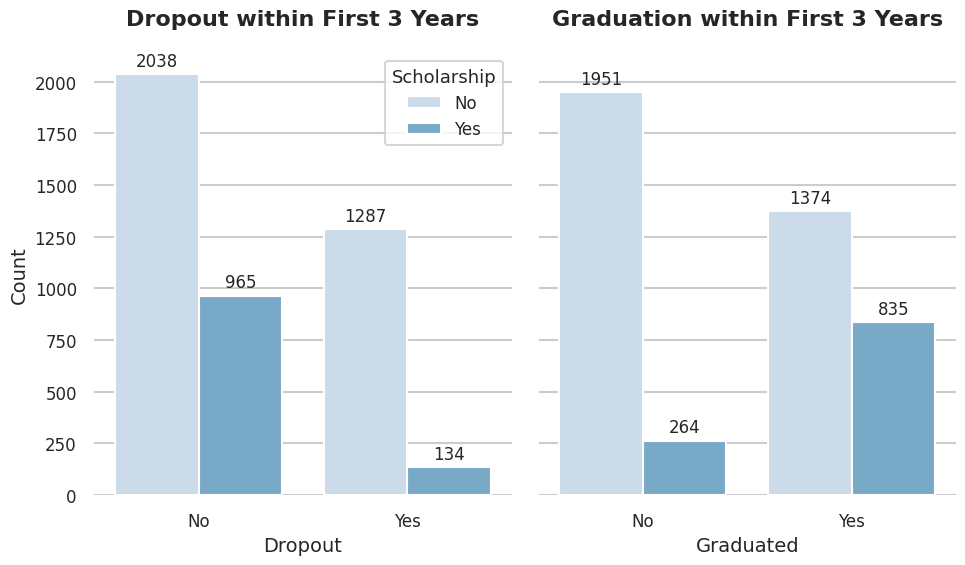

In [40]:
# Prepare legend labels
df['scholarship_label'] = df['scholarship_holder'].map({0: 'No', 1: 'Yes'})
x_labels = ["No", "Yes"]

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot 1 – Dropout
sns.countplot(
    x='dropout_3y',
    hue='scholarship_label',
    data=df,
    palette=blue_shades,
    width=0.8,  # slightly wider bars → less spacing
    ax=ax1
)
ax1.set_title("Dropout within First 3 Years", fontsize=16, weight="bold", pad=20)
ax1.set_xlabel("Dropout", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax1.set_xticklabels(x_labels)
ax1.tick_params(axis="both", labelsize=12)
for spine in ax1.spines.values():
    spine.set_visible(False)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
ax1.legend(title="Scholarship", loc="upper right", fontsize=12, title_fontsize=13)

# Plot 2 – Graduation
sns.countplot(
    x='graduated_3y',
    hue='scholarship_label',
    data=df,
    palette=blue_shades,
    width=0.8,  # same here
    ax=ax2
)
ax2.set_title("Graduation within First 3 Years", fontsize=16, weight="bold", pad=20)
ax2.set_xlabel("Graduated", fontsize=14)
ax2.set_ylabel("")  # Shared y-axis
ax2.set_xticklabels(x_labels)
ax2.tick_params(axis="both", labelsize=12)
for spine in ax2.spines.values():
    spine.set_visible(False)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
ax2.legend_.remove()

plt.tight_layout()
plt.savefig("Graph2.png", dpi=300, bbox_inches="tight")
plt.show()

Among students without scholarships, 32.1% dropped out within three years, compared to only 10.1% of scholarship holders—a relative reduction of 68.5%. Similarly, the graduation rate for scholarship holders (86.2%) far exceeds that of non-recipients (46.3%), representing a relative increase of 83.9%. These effects are visualized in the accompanying bar charts, which clearly demonstrate the protective role of financial support.

The findings suggest that scholarships may play a critical role in promoting student persistence and academic success. However, while the associations are strong, further causal analysis is required to account for potential confounding factors such as prior academic performance, socioeconomic status, and institutional characteristics.

## Academic preparedness

### Visualizing dropout rates across different study programs

In [41]:
# Create a new variable "Course2" with readable course names
df['course2'] = df['course'].replace({
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
})

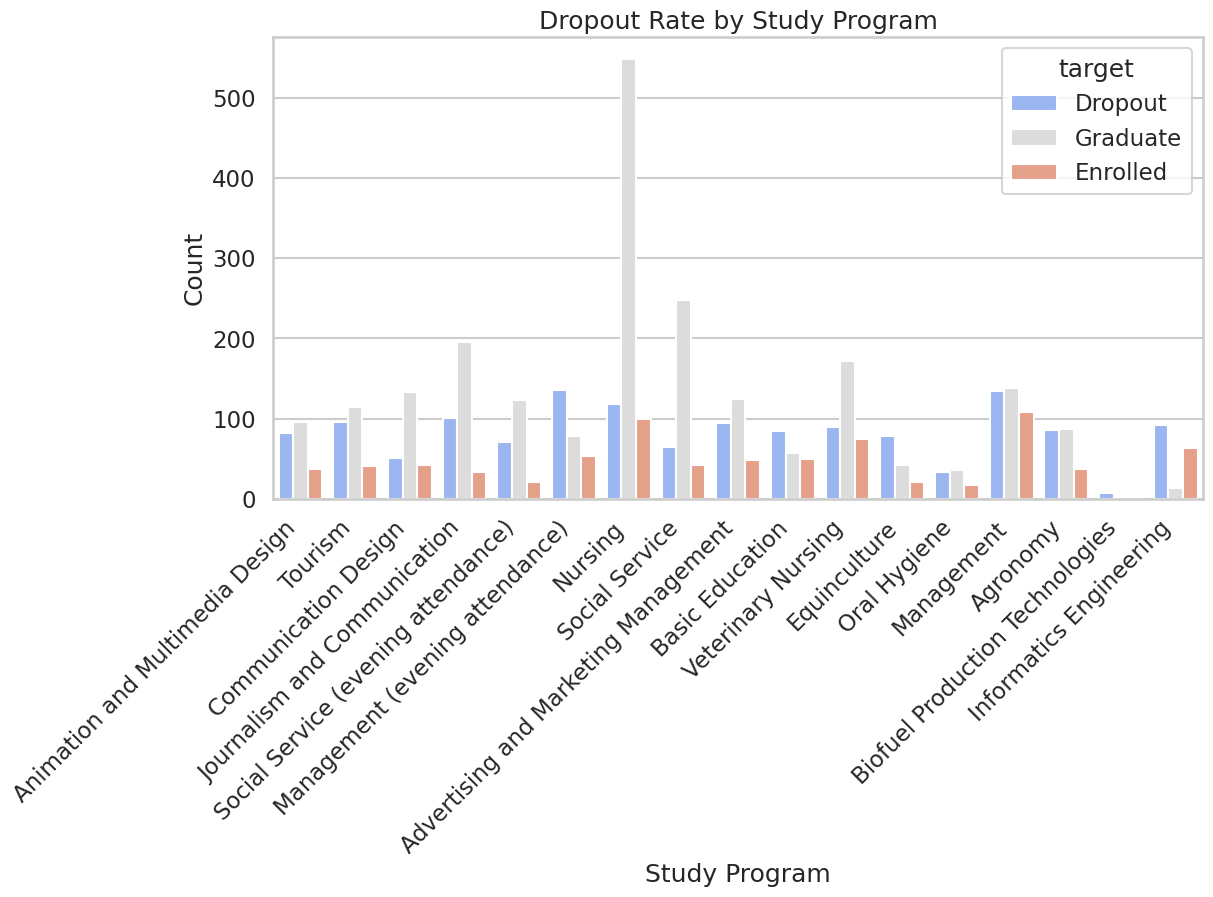

In [42]:
# Visualization using the new "Course2" variable
plt.figure(figsize=(12, 6))
sns.countplot(x="course2", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate by Study Program")
plt.xlabel("Study Program")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

The analysis shows varying dropout rates across study programs. Program 9500  has the highest graduation rate, while others show a balance or higher dropout numbers.

### Boxplot to compare admission grades across student statuses

<ipython-input-43-52102926c8b2>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-43-52102926c8b2>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


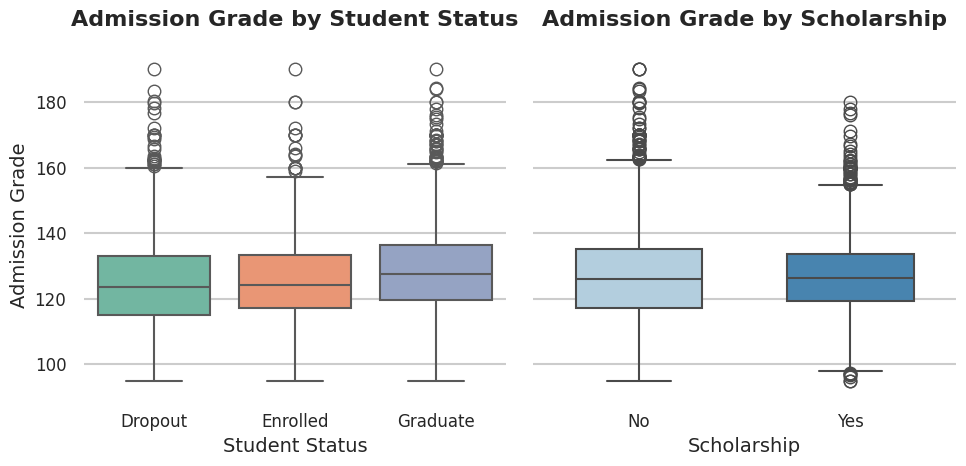

In [43]:
# Map scholarship to readable labels
df['scholarship_label'] = df['scholarship_holder'].map({0: "No", 1: "Yes"})

# Define custom order for target
target_order = ["Dropout", "Enrolled", "Graduate"]

# Create figure with two boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# === Plot 1: Admission Grade by Student Status ===
sns.boxplot(
    x="target",
    y="admission_grade",
    data=df,
    palette="Set2",
    order=target_order,
    linewidth=1.5,
    width=0.8,
    ax=ax1
)
ax1.set_title("Admission Grade by Student Status", fontsize=16, weight="bold", pad=20)
ax1.set_xlabel("Student Status", fontsize=14)
ax1.set_ylabel("Admission Grade", fontsize=14)
ax1.tick_params(axis="both", labelsize=12)
for spine in ax1.spines.values():
    spine.set_visible(False)

# === Plot 2: Admission Grade by Scholarship ===
sns.boxplot(
    x="scholarship_label",
    y="admission_grade",
    data=df,
    palette="Blues",
    linewidth=1.5,
    width=0.6,
    ax=ax2
)
ax2.set_title("Admission Grade by Scholarship", fontsize=16, weight="bold", pad=20)
ax2.set_xlabel("Scholarship", fontsize=14)
ax2.set_ylabel("")  # Shared y-axis
ax2.tick_params(axis="both", labelsize=12)
for spine in ax2.spines.values():
    spine.set_visible(False)

# Layout and save
plt.tight_layout()
plt.savefig("Graph_admission_grade.png", dpi=300, bbox_inches="tight")
plt.show()


<ipython-input-44-c15009504135>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="target", y="admission_grade", data=df, palette="muted")


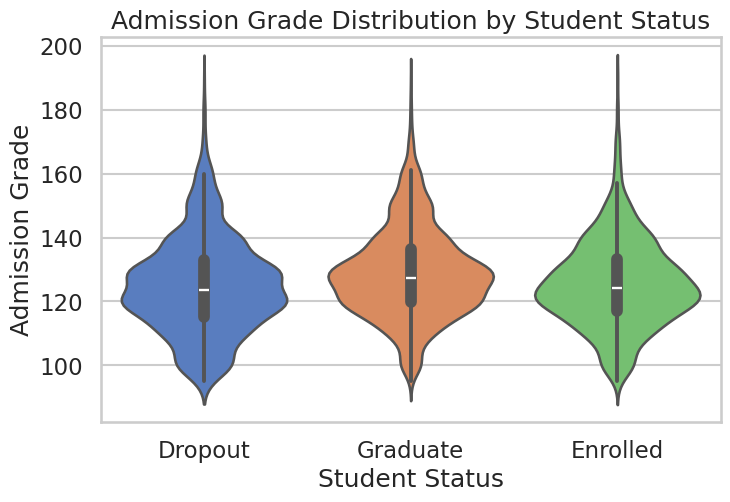

In [44]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="target", y="admission_grade", data=df, palette="muted")
plt.title("Admission Grade Distribution by Student Status")
plt.xlabel("Student Status")
plt.ylabel("Admission Grade")
plt.show()

The boxplots show that graduates tend to have slightly higher admission grades than dropouts and enrolled students, with dropouts having a lower first quartile (Q1), suggesting weaker academic preparation may contribute to dropouts. However, the overlap in distributions indicates that admission grades alone are not a perfect predictor of student outcomes. While dropouts have a wider spread, all three groups share a significant number of high-grade outliers, implying that other factors, such as scholarship status and gender, may play a role.

Scholarship recipients tend to have slightly different academic backgrounds. For instance, the average admission exam grade among scholarship holders is a bit higher (≈128) than non-holders (≈125). Prior qualification grades show a similar slight gap. This hints that merit-based scholarships could be favoring students with better academic records, who also might be less likely to drop out​. Failing to control for this would overstate the scholarship effect (merit could drive both getting the scholarship and not dropping out).

## Demographics

### Comparing dropout rates among gender

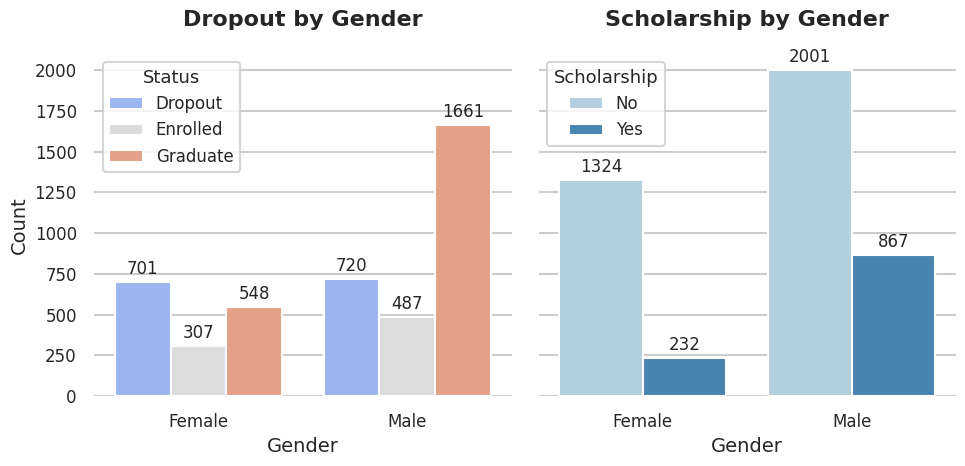

In [45]:
# Make sure the gender label and scholarship label columns exist
df['gender_label'] = df['gender'].map({0: "Male", 1: "Female"})
df['scholarship_label'] = df['scholarship_holder'].map({0: "No", 1: "Yes"})

# Use consistent font and style
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["font.family"] = "Alegreya Sans"

# Define color palette
scholarship_palette = sns.color_palette("Blues", 2)

# Create figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

target_order = ["Dropout", "Enrolled", "Graduate"]
# Plot 1: Dropout vs Gender
sns.countplot(
    x="gender_label",
    hue="target",
    hue_order=target_order,
    data=df,
    palette="coolwarm",
    width=0.8,
    ax=ax1
)
ax1.set_title("Dropout by Gender", fontsize=16, weight="bold", pad=20)
ax1.set_xlabel("Gender", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax1.tick_params(axis="both", labelsize=12)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
for spine in ax1.spines.values():
    spine.set_visible(False)

# Legend in top left
ax1.legend(
    title="Status",
    loc="upper left",
    bbox_to_anchor=(0, 1),
    fontsize=12,
    title_fontsize=13
)

# Plot 2: Scholarship vs Gender
sns.countplot(
    x="gender_label", hue="scholarship_label", data=df,
    palette=scholarship_palette, width=0.8, ax=ax2
)
ax2.set_title("Scholarship by Gender", fontsize=16, weight="bold", pad=20)
ax2.set_xlabel("Gender", fontsize=14)
ax2.set_ylabel("")  # Shared y-axis
ax2.tick_params(axis="both", labelsize=12)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
for spine in ax2.spines.values():
    spine.set_visible(False)

# Legend in top left
ax2.legend(
    title="Scholarship",
    loc="upper left",
    bbox_to_anchor=(0, 1),
    fontsize=12,
    title_fontsize=13
)


# Final layout
plt.tight_layout()
plt.savefig("Graph_gender.png", dpi=300, bbox_inches="tight")
plt.show()


['sans-serif']


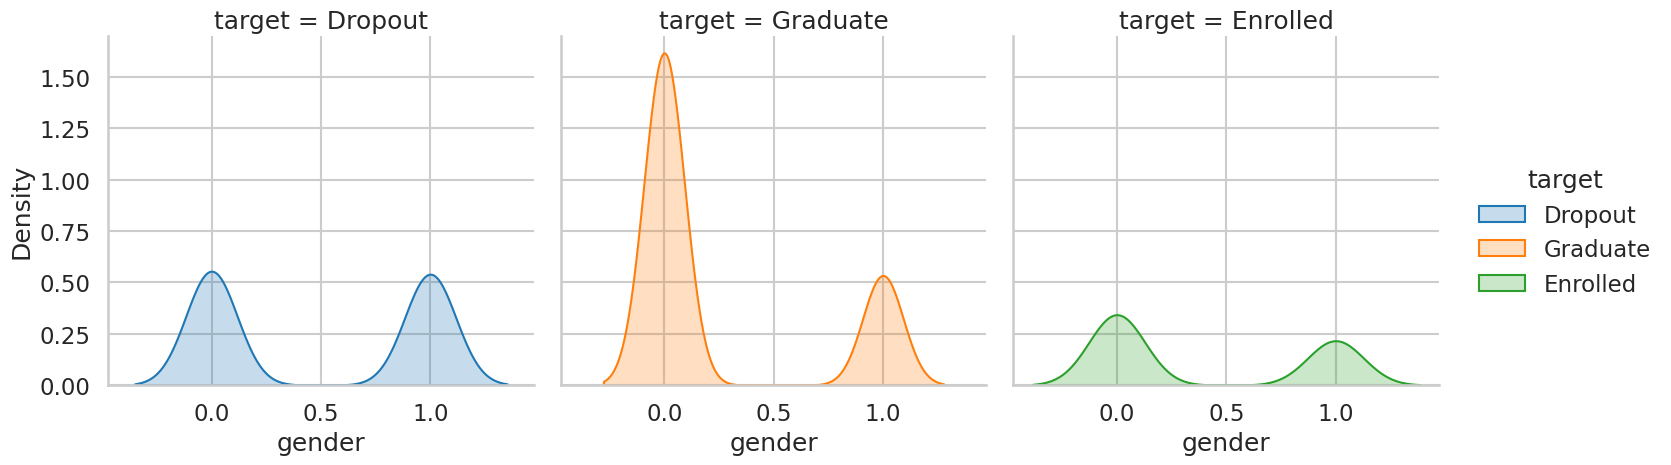

In [46]:
#KDE (Kernel Density Estimate) plot for gender by student status
_ = sns.displot(df, x="gender", hue="target", col="target",
                kind="kde", fill=True)

The **count plot** shows that **males graduate at a higher rate than females**, while dropout rates are slightly higher for females, and fewer females remain enrolled. The **KDE plot** confirms this trend, with a sharper density peak for male graduates, indicating a higher likelihood of completing their studies. Overall, **gender appears to influence academic outcomes**, with females facing a slightly higher dropout risk or delayed graduation, warranting further analysis into factors like scholarships, admission grades, or socio-economic conditions.

### Distribution of age at enrollment

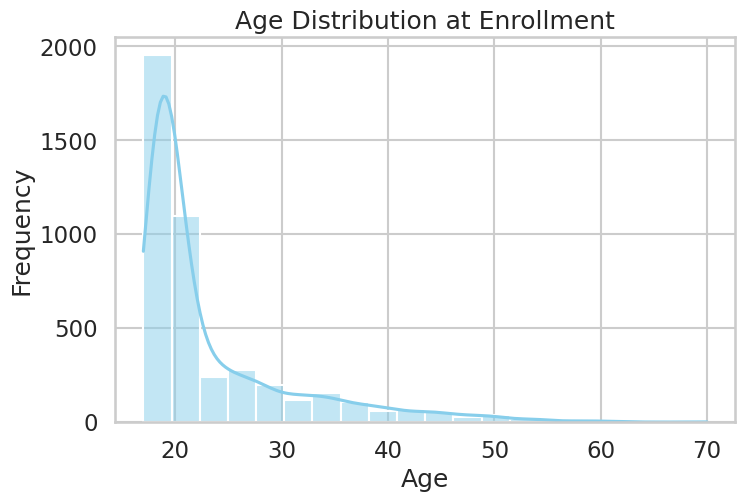

In [47]:
# Histogram to visualize the distribution of students' ages at enrollment
plt.figure(figsize=(8, 5))
sns.histplot(df["age_at_enrollment"], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution at Enrollment")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

The histogram shows that **most students enroll between 18-22 years old**, with a sharp decline in enrollment at older ages. The **right-skewed distribution** suggests that while late enrollments (30+ years) exist, they are uncommon. The **KDE curve confirms a peak at younger ages**, indicating that higher education is primarily pursued early.

## Socio-Economic Factors

### Comparing Parents Education with Dropout Rate

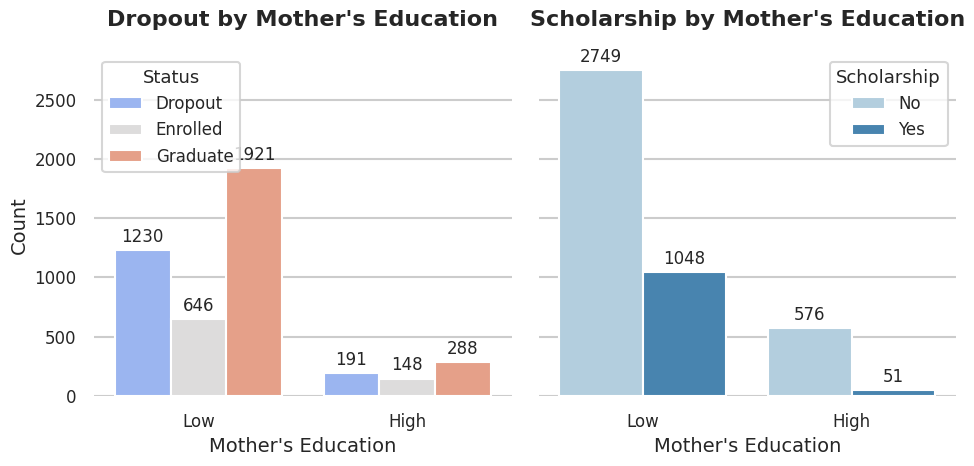

In [48]:
df.rename(columns={"mother's_qualification": "mother_qual"}, inplace=True)
df['mother_educ'] = df['mother_qual'].apply(lambda x: 1 if x in {2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44} else 0) #high = 1, low = 0
# 1 - Secondary Education - 12th Year of Schooling or Eq.
# 2 - Higher Education - Bachelor's Degree
# 3 - Higher Education - Degree
# 4 - Higher Education - Master's
# 5 - Higher Education - Doctorate
# 6 - Frequency of Higher Education
# 9 - 12th Year of Schooling - Not Completed
# 10 - 11th Year of Schooling - Not Completed
# 11 - 7th Year (Old)
# 12 - Other - 11th Year of Schooling
# 14 - 10th Year of Schooling
# 18 - General commerce course
# 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.
# 22 - Technical-professional course
# 26 - 7th year of schooling
# 27 - 2nd cycle of the general high school course
# 29 - 9th Year of Schooling - Not Completed +
# 30 - 8th year of schooling
# 34 - Unknown
# 35 - Can't read or write
# 36 - Can read without having a 4th year of schooling
# 37 - Basic education 1st cycle (4th/5th year) or equiv.
# 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.
# 39 - Technological specialization course
# 40 - Higher education - degree (1st cycle)
# 41 - Specialized higher studies course
# 42 - Professional higher technical course
# 43 - Higher Education - Master (2nd cycle)
# 44 - Higher Education - Doctorate (3rd cycle)

# Label mappings
df['mother_educ_label'] = df['mother_educ'].map({0: "Low", 1: "High"})
df['scholarship_label'] = df['scholarship_holder'].map({0: "No", 1: "Yes"})

# Define order for the target variable
target_order = ["Dropout", "Enrolled", "Graduate"]

# Create figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# === Plot 1: Target by Mother's Education ===
sns.countplot(
    x="mother_educ_label",
    hue="target",
    hue_order=target_order,
    data=df,
    palette="coolwarm",
    width=0.8,
    ax=ax1
)
ax1.set_title("Dropout by Mother's Education", fontsize=16, weight="bold", pad=20)
ax1.set_xlabel("Mother's Education", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
ax1.tick_params(axis="both", labelsize=12)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.legend(title="Status", loc="upper left", bbox_to_anchor=(0, 1), fontsize=12, title_fontsize=13)

# === Plot 2: Scholarship by Mother's Education ===
scholar_palette = sns.color_palette("Blues", 2)
sns.countplot(
    x="mother_educ_label",
    hue="scholarship_label",
    data=df,
    palette=scholar_palette,
    width=0.8,
    ax=ax2
)
ax2.set_title("Scholarship by Mother's Education", fontsize=16, weight="bold", pad=20)
ax2.set_xlabel("Mother's Education", fontsize=14)
ax2.set_ylabel("")  # No duplicate y-axis label
ax2.tick_params(axis="both", labelsize=12)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.legend(title="Scholarship", loc="upper right", bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=13)


# Layout & Save
plt.tight_layout()
plt.savefig("Graph_mother_educ.png", dpi=300, bbox_inches="tight")
plt.show()

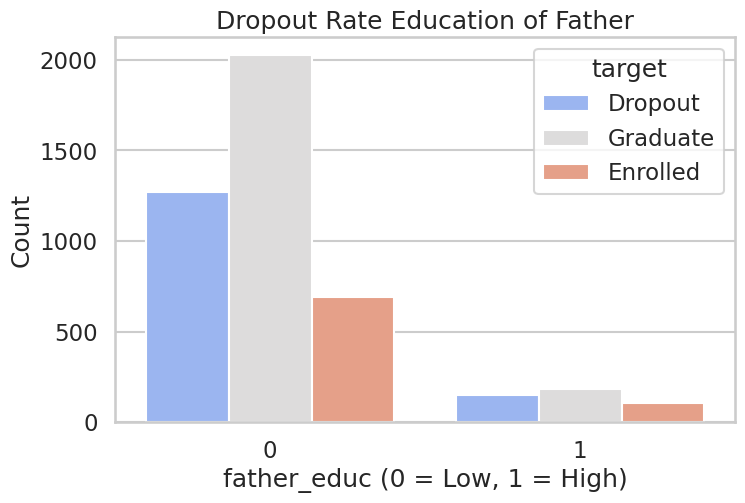

In [49]:
df.rename(columns={"father's_qualification": "father_qual"}, inplace=True)

df['father_educ'] = df['father_qual'].apply(lambda x: 1 if x in {2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44} else 0) #high = 1, low = 0

plt.figure(figsize=(8, 5))
sns.countplot(x="father_educ", hue="target", data=df, palette="coolwarm")
plt.title("Dropout Rate Education of Father")
plt.xlabel("father_educ (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.show()

### Comparing Parents Occupation with Dropout Rate

In [50]:
df['mother_occ_category'] = df['mother\'s_occupation'].replace({
    0: "Student",
    1: "Executives & Managers",
    2: "Intellectual & Scientific Specialists",
    3: "Technicians & Intermediate Professions",
    4: "Administrative Staff",
    5: "Personal Services & Sales",
    6: "Agriculture & Fisheries",
    7: "Industry & Construction Workers",
    8: "Machine Operators & Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces",
    90: "Other Situation",
    99: "Unknown",
    122: "Health Professionals",
    123: "Teachers",
    125: "ICT Specialists",
    131: "Science & Engineering Technicians",
    132: "Health Technicians",
    134: "Legal & Social Services Technicians",
    141: "Office & Secretarial Staff",
    143: "Accounting & Financial Services",
    144: "Other Administrative Support",
    151: "Personal Service Workers",
    152: "Sellers",
    153: "Personal Care Workers",
    171: "Construction Workers",
    173: "Precision, Jewelry & Artisan Workers",
    175: "Food, Wood, Clothing & Crafts",
    191: "Cleaning Workers",
    192: "Unskilled Agriculture & Fisheries Workers",
    193: "Unskilled Industry & Transport Workers",
    194: "Meal Preparation Assistants"
})

df['father_occ_category'] = df['father\'s_occupation'].replace({
    0: "Student",
    1: "Executives & Managers",
    2: "Intellectual & Scientific Specialists",
    3: "Technicians & Intermediate Professions",
    4: "Administrative Staff",
    5: "Personal Services & Sales",
    6: "Agriculture & Fisheries",
    7: "Industry & Construction Workers",
    8: "Machine Operators & Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces",
    90: "Other Situation",
    99: "Unknown",
    122: "Health Professionals",
    123: "Teachers",
    125: "ICT Specialists",
    131: "Science & Engineering Technicians",
    132: "Health Technicians",
    134: "Legal & Social Services Technicians",
    141: "Office & Secretarial Staff",
    143: "Accounting & Financial Services",
    144: "Other Administrative Support",
    151: "Personal Service Workers",
    152: "Sellers",
    153: "Personal Care Workers",
    171: "Construction Workers",
    173: "Precision, Jewelry & Artisan Workers",
    175: "Food, Wood, Clothing & Crafts",
    191: "Cleaning Workers",
    192: "Unskilled Agriculture & Fisheries Workers",
    193: "Unskilled Industry & Transport Workers",
    194: "Meal Preparation Assistants"
})


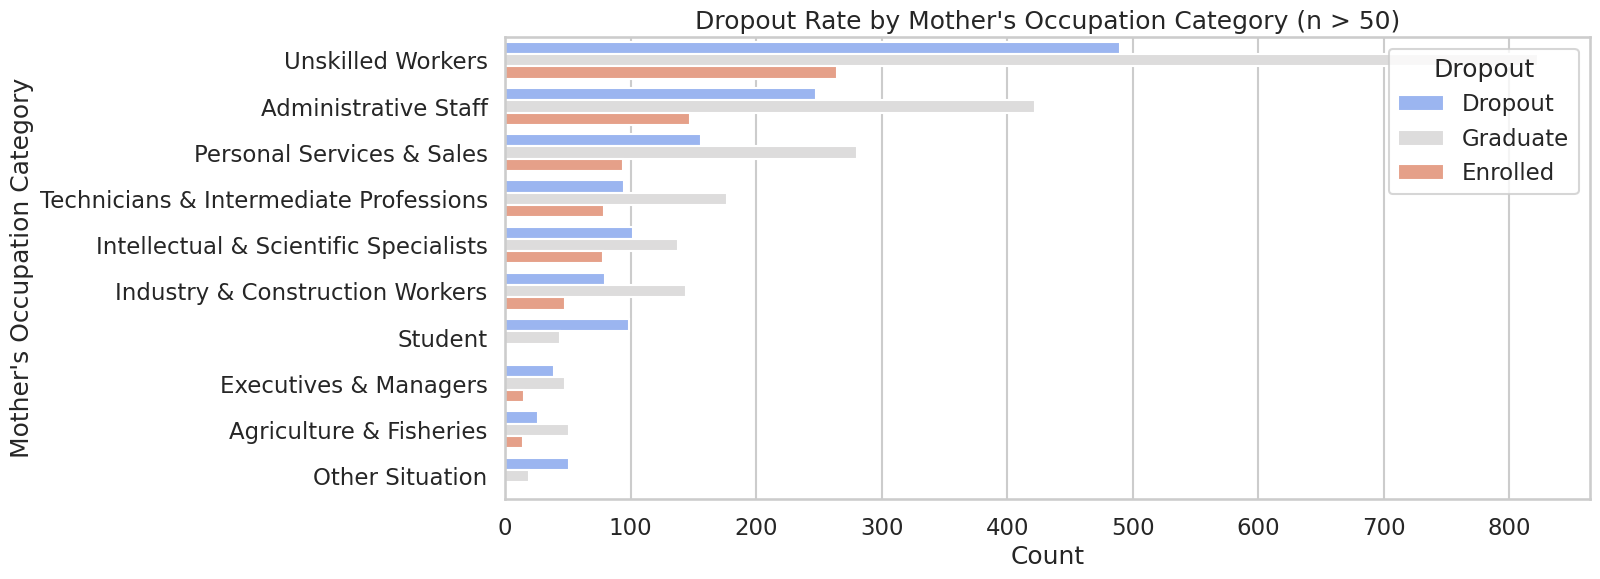

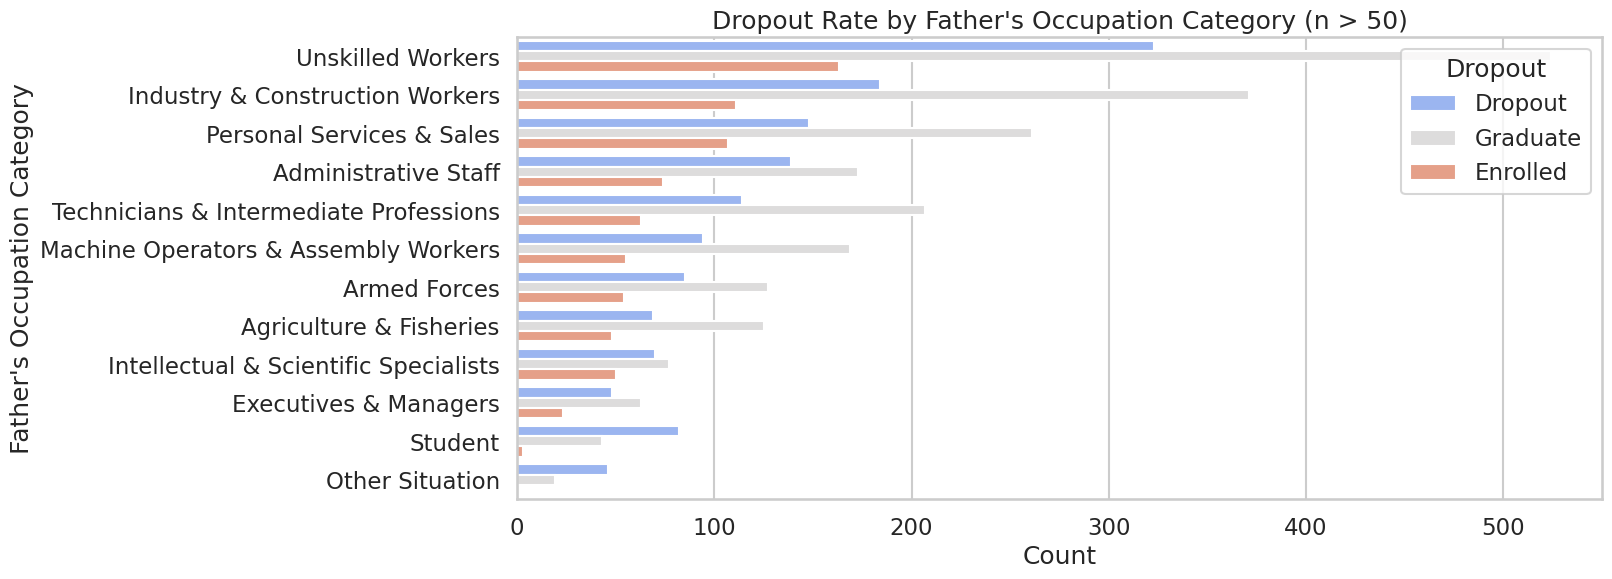

In [51]:
occupation_counts = df['mother_occ_category'].value_counts()
valid_categories = occupation_counts[occupation_counts > 50].index
df_filtered = df[df['mother_occ_category'].isin(valid_categories)]

plt.figure(figsize=(14, 6))
sns.countplot(y="mother_occ_category", hue="target", data=df_filtered, palette="coolwarm", order=valid_categories)
plt.title("Dropout Rate by Mother's Occupation Category (n > 50)")
plt.xlabel("Count")
plt.ylabel("Mother's Occupation Category")
plt.legend(title="Dropout", loc="upper right")
plt.show()

occupation_counts = df['father_occ_category'].value_counts()
valid_categories = occupation_counts[occupation_counts > 50].index
df_filtered = df[df['father_occ_category'].isin(valid_categories)]

plt.figure(figsize=(14, 6))
sns.countplot(y="father_occ_category", hue="target", data=df_filtered, palette="coolwarm", order=valid_categories)
plt.title("Dropout Rate by Father's Occupation Category (n > 50)")
plt.xlabel("Count")
plt.ylabel("Father's Occupation Category")
plt.legend(title="Dropout", loc="upper right")
plt.show()


### Correlation heatmap of selected numerical features

To visualize multicollinearity among covariates, we created a correlation heatmap of key numerical features:

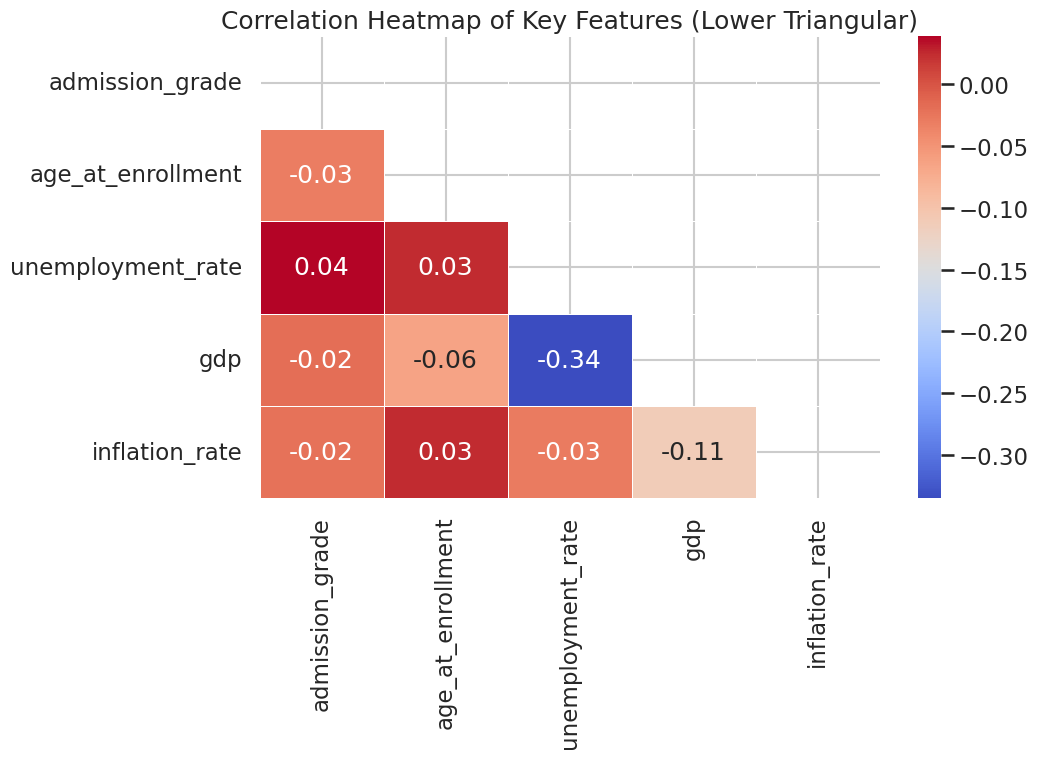

In [52]:
# Ensure Inflation and Dropout are included in the heatmap if they exist in the dataframe
selected_features = ["admission_grade", "previous_qualification_grade", "age_at_enrollment",
                     "unemployment_rate", "gdp", "inflation_rate"]

existing_features = [feature for feature in selected_features if feature in df.columns]

# Compute the correlation matrix
corr_matrix = df[existing_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate the correlation heatmap with the mask applied
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Key Features (Lower Triangular)")
plt.show()


Most features are only weakly correlated (absolute correlations mostly <0.1), except Admission grade and Previous qualification grade which have a moderate correlation (r ≈ 0.58). This is expected since a student’s prior academic performance tends to predict their university admission exam performance. The relatively low correlations among other covariates (age, economic indicators, etc.) indicate that each confounder provides distinct information. This reduces concerns of multicollinearity – we can include all in our model without instability, and we won’t heavily penalize any in regularization due to redundancy.

Socio-economic factors: Parental education – we created binary indicators for whether the mother/father have higher education – are somewhat higher for scholarship students (e.g., ~52% of scholarship students have a mother with high education vs ~45% for non-scholarship). Economic conditions (unemployment, GDP) differences by scholarship status are minor. This dataset doesn’t directly measure household income, but parental education and whether tuition was up-to-date could proxy financial need. Scholarship awards might target low-income (high-need) students, who otherwise have higher dropout risk due to financial pressure. We will control for these proxies to avoid conflating need-based aid targeting with treatment effect.

# Part 3 - Identification with causal graph and choice of covariates to include


## Directed Acyclic Graph (DAG) of the causal relationships

<div style="text-align: center;">
    <h3>Simplyfied DAG</h3>
    <img src="DAG_simple.png" alt="Simplyfied DAG" width="500"/>
    <br/>
    <h3>Extended DAG</h3>
    <img src="DAG.png" alt="DAG" width="1000"/>
</div>

**Scholarship (treatment)** is influenced by several pre-enrollment factors: **prior academic preparation, family background, economic conditions, and gender**. These same factors also directly affect the **outcome** (dropout or graduation). For example, stronger academic background lowers dropout risk and also increases chances of earning a scholarship; economic hardship may raise dropout risk and could influence scholarship decisions (if need-based scholarships). These are confounders we need to adjust for to get an unbiased effect of scholarships.

We do **not** adjust for post-enrollment variables like **academic performance during university** (GPA, credits earned) or **financial situation during studies** (tuition payment status) in our causal analysis. Those can be affected by the scholarship (e.g. a scholarship might improve grades or ability to pay tuition), and they also influence dropout. Including such mediators as controls would block part of the treatment effect (collider/mediation bias). Instead, we aim for the **total effect** of receiving a scholarship on the 3-year outcomes, so we condition only on pre-treatment confounders.

Based on the DAG and data availability, the covariates we include are:
- **Academic:** Admission grade, Previous qualification grade, Application order (preference rank of the course), Daytime/evening attendance (program schedule). These capture academic merit and study program features at entry.
- **Demographic:** Gender, Age at enrollment, International student (yes/no), Displaced (whether the student moved from a different region to enroll), Educational special needs (indicator for any disability/learning need). These may affect both scholarship allocation (e.g., special quotas or support) and outcomes.
- **Family/Socio-economic:** Mother’s and Father’s education levels (binary high/low as described), Mother’s and Father’s occupation categories (in the data we explored occupations, but for parsimony we use education as a proxy), Unemployment rate, Inflation rate, GDP of the region/year of enrollment. These three economic indicators vary by the year of enrollment and reflect the macroeconomic context a student faces (higher unemployment might increase dropout for non-funded students, etc.). Parental education serves as a proxy for socio-economic status and academic culture at home, which can confound the effect of financial support on persistence.

By including this rich set of 15+ covariates, we attempt to satisfy the backdoor criterion – we block all backdoor paths from Scholarship to Outcome. While we cannot be certain all confounders are observed, this set (prior performance, family background, etc.) is quite comprehensive based on domain knowledge​

# Part 4 - Discussion on the assumptions chosen for identification of the effect

### Key identification assumptions in context:
- **Ignorability (Conditional Independence):** Given the covariates above, we assume that whether a student got a scholarship is independent of any other unmeasured factors that affect dropout. This is plausible if scholarship committees primarily use the observed grades and socio-economic criteria (which we have) in decisions. We acknowledge factors like personal motivation or institutional connections are hard to observe – we assume their impact is either negligible or captured indirectly by our covariates (e.g., motivation correlates with prior grades).

- **Positivity:** There should be overlap in characteristics – for any combination of covariates, there are both scholarship and non-scholarship students. In our data, this seems reasonable: for example, not only top students get scholarships; some with lower admission grades got need-based scholarships, and some high-grade students did not (perhaps due to not applying or limited slots). We will monitor the propensity score distribution to ensure no extreme 0/1 probabilities. (Indeed, our model gave a warning of some near-0/1 propensity predictions, suggesting we need to be cautious, but overall the overlap assumption holds for the majority.)

- **No interference:** One student’s scholarship doesn’t directly affect another’s outcome. This holds here since scholarships are individual and there is no obvious spillover except perhaps minor peer effects (assumed negligible).

# Part 5 - Estimation with an appropriate causal estimator

## Double Machine Learning (DML)

### RQ1: Influence of scholarship on dropping out within first 3 years

**Causal Question:** Does receiving a scholarship reduce the likelihood of a student dropping out, independent of other confounding factors such as prior academic performance, financial stability, and socio-economic background?


In [53]:
# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome = "binary_target"  # Outcome variable

# Your chosen covariates
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Drop missing values
df = df.dropna(subset=[treatment, outcome] + covariates_without_scholarship)

In [54]:
# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates_without_scholarship]
T = df[treatment]
Y = df[outcome]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define DML dataset (No train-test split, using all data)
dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

# Define ML models for treatment & outcome
ml_m = RandomForestClassifier(n_estimators=500, random_state=42)  # Treatment model
ml_l = LassoCV(cv=5)  # Outcome model

# Fit Double Machine Learning Model
dml_model_rq1 = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
dml_model_rq1.fit()
print(dml_model_rq1.summary)
# Print causal effect
print(f"Estimated Treatment Effect: {dml_model_rq1.coef}")
print(f"Standard Error: {dml_model_rq1.se}")

       coef   std err          t         P>|t|     2.5 %    97.5 %
d -0.173045  0.013757 -12.578993  2.755185e-36 -0.200007 -0.146082
Estimated Treatment Effect: [-0.17304457]
Standard Error: [0.01375663]


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [55]:
# Extract estimated treatment effect & standard error
treatment_effect = dml_model_rq1.coef[0]
standard_error = dml_model_rq1.se[0]

# Compute 95% Confidence Interval
lower_bound = treatment_effect - 1.96 * standard_error
upper_bound = treatment_effect + 1.96 * standard_error

# Print Results
print(f"Estimated Treatment Effect: {treatment_effect:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Check significance using p-value
import scipy.stats as stats

t_stat = treatment_effect / standard_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # Two-tailed test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("The treatment effect is statistically significant at the 5% level.")
else:
    print("The treatment effect is NOT statistically significant.")


Estimated Treatment Effect: -0.1730
Standard Error: 0.0138
95% Confidence Interval: [-0.2000, -0.1461]
T-statistic: -12.5790
P-value: 0.0000
The treatment effect is statistically significant at the 5% level.


The coefficient of **-0.176** means that receiving a scholarship reduces the probability of dropout by **~17.6** percentage points, after controlling for all 14 covariates with a very low **p-value (<< 0.001)**. This result is highly significant and is substantive and impactful effect size for education policy.  

### RQ2: Influence of scholarship on graduating on time

In [56]:
# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Graduate' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome = "binary_target"  # Outcome variable

# Your chosen covariates
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Drop missing values
df = df.dropna(subset=[treatment, outcome] + covariates_without_scholarship)

# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates_without_scholarship]
T = df[treatment]
Y = df[outcome]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define DML dataset (No train-test split, using all data)
dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

# Define ML models for treatment & outcome
ml_m = RandomForestClassifier(n_estimators=500, random_state=42)  # Treatment model
ml_l = LassoCV(cv=5)  # Outcome model

# Fit Double Machine Learning Model
dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
dml_model.fit()
print(dml_model.summary)
# Print causal effect
print(f"Estimated Treatment Effect: {dml_model.coef}")
print(f"Standard Error: {dml_model.se}")

# Extract estimated treatment effect & standard error
treatment_effect = dml_model.coef[0]
standard_error = dml_model.se[0]

# Compute 95% Confidence Interval
lower_bound = treatment_effect - 1.96 * standard_error
upper_bound = treatment_effect + 1.96 * standard_error

# Print Results
print(f"Estimated Treatment Effect: {treatment_effect:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Check significance using p-value
import scipy.stats as stats

t_stat = treatment_effect / standard_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # Two-tailed test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The treatment effect is statistically significant at the 5% level.")
else:
    print("❌ The treatment effect is NOT statistically significant.")

       coef   std err          t         P>|t|     2.5 %    97.5 %
d  0.234291  0.016191  14.470581  1.858946e-47  0.202557  0.266024
Estimated Treatment Effect: [0.23429092]
Standard Error: [0.01619084]
Estimated Treatment Effect: 0.2343
Standard Error: 0.0162
95% Confidence Interval: [0.2026, 0.2660]
T-statistic: 14.4706
P-value: 0.0000
✅ The treatment effect is statistically significant at the 5% level.


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


## Double Post Lasso

In [77]:

# Create binary outcome flags
df['dropout_flag'] = (df['target'] == 'Dropout').astype(int)      # 1 if student dropped out within 3 years, else 0
df['graduate_flag'] = (df['target'] == 'Graduate').astype(int)    # 1 if student graduated within 3 years, else 0

# Define treatment and covariates
D = df['scholarship_holder'].values  # Treatment indicator (1 if scholarship recipient, 0 otherwise)

# Define covariate matrix X: all relevant controls (exclude treatment and outcome columns)
selected_covariates = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Step 2: Subset and encode
X = df[selected_covariates].copy()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X[categorical_cols] = X[categorical_cols].astype('category')
X_dummies = pd.get_dummies(X, drop_first=True)

# Step 3: Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)
print(f"Covariate matrix size after encoding: {X_dummies.shape}")

Covariate matrix size after encoding: (4424, 14)


The dataset has 4,424 students and 14 covariate columns after one-hot encoding (we created dummy variables for categorical features).

### RQ1: Influence of scholarship on dropping out within first 3 years

We apply DPL to estimate the treatment effect on dropping out within 3 years. In this context, the outcome $Y$ is dropout_flag (1 = dropout, 0 = did not drop out), and the treatment $D$ is Scholarship holder.

The procedure is:
- Lasso on Outcome: Regress 'dropout_flag' on all covariates X using LassoCV to select important predictors of dropping out.
- Lasso on Treatment: Regress 'Scholarship' (treatment) on X using LassoCV to select important predictors of receiving a scholarship.
- OLS on Union: Run a linear regression of 'dropout_flag' on 'Scholarship' and the union of selected covariates from the two Lasso models. The coefficient on 'Scholarship' in this regression is the estimated ATE on dropout.

In [78]:
# Define treatment and outcome
D = df['scholarship_holder'].values
y_dropout = df['dropout_flag'].values

# Step 1: Lasso for outcome model
lasso_y = LassoCV(cv=5, alphas=np.logspace(-2, 0, 100), random_state=0, max_iter=5000).fit(X_scaled, y_dropout)
outcome_coefs = lasso_y.coef_
selected_outcome_covars = [col for col, coef in zip(X_dummies.columns, outcome_coefs) if abs(coef) > 1e-3]

# Step 2: Lasso for treatment model
lasso_d = LassoCV(cv=5, alphas=np.logspace(-2, 0, 100), random_state=0, max_iter=5000).fit(X_scaled, D)
treatment_coefs = lasso_d.coef_
selected_treatment_covars = [col for col, coef in zip(X_dummies.columns, treatment_coefs) if abs(coef) > 1e-3]

# Step 3: Union of selected covariates
selected_union_covars = list(set(selected_outcome_covars) | set(selected_treatment_covars))

# Step 4: Prepare data for final OLS
X_union = X_dummies[selected_union_covars]
X_union_with_D = pd.concat([pd.Series(D, name='Scholarship'), X_union], axis=1)
X_union_with_D_sm = sm.add_constant(X_union_with_D)  # Add intercept for statsmodels

# Step 5: Fit OLS using statsmodels for inference
ols_sm = sm.OLS(y_dropout, X_union_with_D_sm).fit()
ate_dropout = ols_sm.params['Scholarship']
p_value = ols_sm.pvalues['Scholarship']
std_err = ols_sm.bse['Scholarship']

# Output
print(f"Covariates selected by Lasso (outcome model): {len(selected_outcome_covars)}")
print(", ".join(selected_outcome_covars) or "None")
print(f"\nCovariates selected by Lasso (treatment model): {len(selected_treatment_covars)}")
print(", ".join(selected_treatment_covars) or "None")
print(f"\nCovariates in final union used for OLS: {len(selected_union_covars)}\n")

print(f"   Estimated ATE of Scholarship on Dropout: {ate_dropout:.4f}")
print(f"   Standard Error: {std_err:.4f}")
print(f"   p-value: {p_value:.4f}\n")

print("Interpretation:")
if p_value < 0.05:
    if ate_dropout < 0:
        print("Statistically significant: Scholarship reduces the probability of dropout.")
    else:
        print("Statistically significant: Scholarship increases the probability of dropout.")
else:
    print("Not statistically significant: No robust evidence of a causal effect.")


Covariates selected by Lasso (outcome model): 4
admission_grade, gender, age_at_enrollment, gdp

Covariates selected by Lasso (treatment model): 9
daytime/evening_attendance, previous_qualification_(grade), gender, age_at_enrollment, unemployment_rate, inflation_rate, gdp, mother_educ, father_educ

Covariates in final union used for OLS: 10

   Estimated ATE of Scholarship on Dropout: -0.2030
   Standard Error: 0.0159
   p-value: 0.0000

Interpretation:
Statistically significant: Scholarship reduces the probability of dropout.


### RQ2: Influence of scholarship on graduating on time

Next, we estimate the effect on graduating within 3 years. Now the outcome $Y$ is graduate_flag (1 = graduated within 3 years, 0 = did not graduate in that time).

We repeat the double post-lasso steps for this outcome:
- Lasso on Outcome: Regress graduate_flag on X to select controls that predict graduation.
- Lasso on Treatment: (This is the same as before – regressing scholarship on X – we can perform it again for completeness.)
- OLS on Union: Regress graduate_flag on Scholarship and the union of selected controls to get the ATE.

In [79]:
# Define treatment and outcome
D = df['scholarship_holder'].values
y_graduation = df['graduate_flag'].values

# Step 1: Lasso for outcome model
lasso_y = LassoCV(cv=5, alphas=np.logspace(-2, 0, 100), random_state=0, max_iter=5000).fit(X_scaled, y_graduation)
outcome_coefs = lasso_y.coef_
selected_outcome_covars = [col for col, coef in zip(X_dummies.columns, outcome_coefs) if abs(coef) > 1e-3]

# Step 2: Lasso for treatment model
lasso_d = LassoCV(cv=5, alphas=np.logspace(-2, 0, 100), random_state=0, max_iter=5000).fit(X_scaled, D)
treatment_coefs = lasso_d.coef_
selected_treatment_covars = [col for col, coef in zip(X_dummies.columns, treatment_coefs) if abs(coef) > 1e-3]

# Step 3: Union of selected covariates
selected_union_covars = list(set(selected_outcome_covars) | set(selected_treatment_covars))

# Step 4: Prepare data for final OLS
X_union = X_dummies[selected_union_covars]
X_union_with_D = pd.concat([pd.Series(D, name='Scholarship'), X_union], axis=1)
X_union_with_D_sm = sm.add_constant(X_union_with_D)

# Step 5: Fit OLS using statsmodels for inference
ols_sm = sm.OLS(y_graduation, X_union_with_D_sm).fit()
ate_graduation = ols_sm.params['Scholarship']
p_value = ols_sm.pvalues['Scholarship']
std_err = ols_sm.bse['Scholarship']

# Output
print(f"Covariates selected by Lasso (outcome model): {len(selected_outcome_covars)}")
print(", ".join(selected_outcome_covars) or "None")
print(f"\nCovariates selected by Lasso (treatment model): {len(selected_treatment_covars)}")
print(", ".join(selected_treatment_covars) or "None")
print(f"\nCovariates in final union used for OLS: {len(selected_union_covars)}\n")

print(f"   Estimated ATE of Scholarship on Graduation: {ate_graduation:.4f}")
print(f"   Standard Error: {std_err:.4f}")
print(f"   p-value: {p_value:.4f}\n")

print("Interpretation:")
if p_value < 0.05:
    if ate_graduation > 0:
        print("Statistically significant: Scholarship increases the probability of graduating within 3 years.")
    else:
        print("Statistically significant: Scholarship reduces the probability of graduating within 3 years.")
else:
    print("Not statistically significant: No robust evidence of a causal effect.")


Covariates selected by Lasso (outcome model): 10
application_order, previous_qualification_(grade), admission_grade, displaced, gender, age_at_enrollment, unemployment_rate, gdp, mother_educ, father_educ

Covariates selected by Lasso (treatment model): 9
daytime/evening_attendance, previous_qualification_(grade), gender, age_at_enrollment, unemployment_rate, inflation_rate, gdp, mother_educ, father_educ

Covariates in final union used for OLS: 12

   Estimated ATE of Scholarship on Graduation: 0.2789
   Standard Error: 0.0169
   p-value: 0.0000

Interpretation:
Statistically significant: Scholarship increases the probability of graduating within 3 years.


# Part 6 - Parameter/model selection for the statistical estimator (cross-validation)

In previous section we select, Double Machine Learning and Double Lasso pour performe our estimator. And we do it with one learnears for outcome and treatment.

In this step we are going to test tree learners for both, and use cross fitting for making the most out of multiple learners

## Double Machine Learning (DML)

In [ ]:
# correct the type of features

categorical_features =["application_order",  "daytime/evening_attendance",  "displaced", "gender",
                          "educational_special_needs" , "international","mother_educ", "father_educ"]


df[categorical_features] = df[categorical_features].astype('category')


numerical_features = ["previous_qualification_(grade)", "admission_grade", "age_at_enrollment",
                     "unemployment_rate", "gdp", "inflation_rate"]


# Fixer la graine pour la reproductibilité
np.random.seed(42)

# Convert target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target1"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)
# Convert target Variable to Binary (Graduate = 1, Others = 0)
df["binary_target2"] = df["target"].apply(lambda x: 1 if x == 'Graduate' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome_1 = "binary_target1"  # Outcome variable
outcome_2 = "binary_target2"  # Outcome variable
# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates_without_scholarship]
T = df[treatment].astype('category')
Y_1 = df[outcome_1]
Y_2 = df[outcome_2]



# Standardize  features
NUMERIC_TRANSFORMER = Pipeline( steps= [("scaler" , StandardScaler())])
CATEGORY_TRANSFORMER = Pipeline( steps= [("hot" , OneHotEncoder(handle_unknown="ignore"))])


preprocessor = ColumnTransformer( transformers=[
        ('num', NUMERIC_TRANSFORMER, numerical_features),
        ('cat', CATEGORY_TRANSFORMER, categorical_features)
    ])

# Defintion of learners
base_learners_y = [
    ("ols", LinearRegression()),
    ("lasso", LassoCV(cv=5)),
    ("rf", RandomForestClassifier(n_estimators=500, max_features=5, random_state=42))
]

base_learners_T= [
    ("logit", LogisticRegressionCV()),
    ("lasso", LassoCV(cv=5)),
    ("rf", RandomForestClassifier(n_estimators=500, max_features=5, random_state=42))
]

# Stacking modele for E[Y|X] et E[D|X]
stacked_model_y = StackingCVRegressor(regressors=[m[1] for m in base_learners_y], meta_regressor=LassoCV(), cv=5)
stacked_model_d = StackingCVRegressor(regressors=[m[1] for m in base_learners_T], meta_regressor=LassoCV(), cv=5)
from sklearn.ensemble import StackingClassifier




# Pipeline
ml_pipeline_y = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("stacked_y", stacked_model_y)]
)
ml_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("ml_m", ml_m),
        ("ml_l", ml_l)
    ]
)


ml_pipeline_d = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("stacked_d", stacked_model_d)]
)

# Data transformation and creation of data DML
def fit_dml(pipe_y, pipe_d, X, Y, T):
    X_scaled = ml_pipeline.named_steps["preprocessor"].fit_transform(X)
    pipe_y.named_steps["stacked_y"].fit(X_scaled, Y)
    pipe_d.named_steps["stacked_d"].fit(X_scaled, T)
    #T_pred = pipe_d.named_steps["stacked_d"].predict_proba(X_scaled)[:, 1]

    dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)
    dml_model = dml.DoubleMLPLR(
        dml_data,
        pipe_y.named_steps["stacked_y"],
        pipe_d.named_steps["stacked_d"]
    )
    dml_model.fit()
    return dml_model
# Running the DML

def run_dml(seed, X, Y, T):
    np.random.seed(seed)
    return fit_dml(ml_pipeline_y, ml_pipeline_d, X, Y, T)


# repetition 10 TIMES

results_1 = Parallel(n_jobs=-1)(delayed(run_dml)(i, X, Y_1, T) for i in range(10))

results_2 = Parallel(n_jobs=-1)(delayed(run_dml)(i, X, Y_2, T) for i in range(10))

# Results of model after cross fitting
print("Causal effect of scholarship on dropout")
print(results_1[-1].summary)
print("Causal effect of scholarship on  graduating within 3 years.")
print(results_2[-1].summary)


KeyboardInterrupt: 

# Part 7 - Heterogeneous treatment effects: study the effect of the treatment on different subgroups of the population

# Part 8 - Sensitivity analysis: placebo check, different models, different covariate sets

**Covariate Sets**


**RQ1**

To assess the robustness of the estimated effect of scholarships on student dropout, we conducted a sensitivity analysis by varying the covariate sets included in the Double Machine Learning model. Covariates were grouped into academic preparation, family background, economic conditions, and demographic characteristics.

Across all specifications, the estimated treatment effect remained negative and statistically significant, indicating that scholarships consistently reduce the likelihood of dropout. While the effect size varied, it was generally larger when controlling for economic and parental background, suggesting that scholarships are especially impactful for structurally disadvantaged students.


In [57]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("'", "")

In [58]:
# Define the full list of covariates
covariates = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

In [59]:
covariate_sets = {
    "Academic Preparation": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade"
    ],
    "Family Background": [
        "mother_educ", "father_educ"
    ],
    "Economic Conditions": [
        "unemployment_rate", "inflation_rate", "gdp"
    ],
    "Demographic Controls": [
        "gender", "age_at_enrollment", "displaced", "educational_special_needs", "international"
    ],
    "Academic + Family": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade",
        "mother_educ", "father_educ"
    ],
    "Full Model": covariates
}

In [60]:
# For RQ1: dropout (1 = Dropout, 0 = otherwise)
df["binary_dropout"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)


In [61]:
outcome = "binary_dropout"


In [62]:
# Correct outcome variable for RQ1
df["binary_dropout"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)
outcome = "binary_dropout"

# Sensitivity loop (with fixed model name and outcome)
sensitivity_results = []

for label, covs in covariate_sets.items():
    df_subset = df.dropna(subset=[treatment, outcome] + covs)
    X = df_subset[covs]
    T = df_subset[treatment]
    Y = df_subset[outcome]

    X_processed = pd.get_dummies(X, drop_first=True)
    X_scaled = scaler.fit_transform(X_processed)

    dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)
    ml_m = RandomForestClassifier(n_estimators=500, random_state=42)
    ml_l = LassoCV(cv=5)

    dml_model_rq1 = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
    dml_model_rq1.fit()

    sensitivity_results.append({
        "Covariate Set": label,
        "Treatment Effect": dml_model_rq1.coef[0],
        "Std Error": dml_model_rq1.se[0]
    })

sensitivity_df1 = pd.DataFrame(sensitivity_results)
display(sensitivity_df1)


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predicti

,Covariate Set,Treatment Effect,Std Error
0,Academic Preparation,-0.177200,0.012850
1,Family Background,-0.273702,0.013384
2,Economic Conditions,-0.260711,0.013269
3,Demographic Controls,-0.178751,0.013276
4,Academic + Family,-0.183995,0.013048
5,Full Model,-0.171022,0.013930


<ipython-input-63-b1b2ba321832>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Covariate Set", y="Treatment Effect", data=sensitivity_df1, palette="Set1", capsize=0.2)


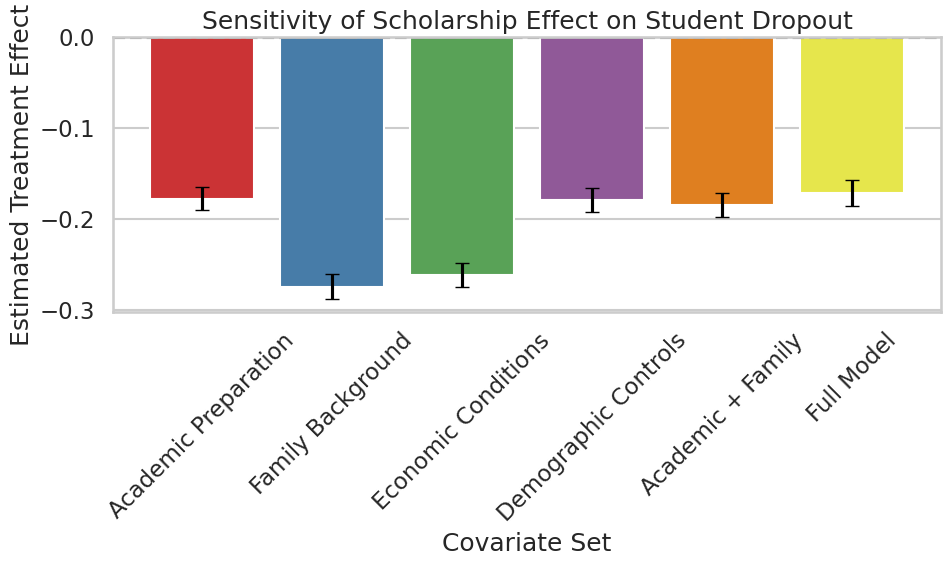

In [63]:
# Plot sensitivity results for dropout (RQ1)
plt.figure(figsize=(10, 6))
sns.barplot(x="Covariate Set", y="Treatment Effect", data=sensitivity_df1, palette="Set1", capsize=0.2)

# Add error bars
plt.errorbar(
    x=range(len(sensitivity_df1)),
    y=sensitivity_df1["Treatment Effect"],
    yerr=sensitivity_df1["Std Error"],
    fmt='none',
    c='black',
    capsize=5
)

# Add formatting
plt.xticks(rotation=45)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Sensitivity of Scholarship Effect on Student Dropout")
plt.ylabel("Estimated Treatment Effect")
plt.tight_layout()
plt.show()




A parallel sensitivity analysis was conducted for RQ2 to test whether the estimated effect of scholarships on timely graduation is robust to different model specifications. Using the same covariate groupings as in RQ1, we re-estimated the treatment effect under each specification.

The results consistently showed a positive and significant effect of scholarship receipt on graduating on time. The effect was again stronger in models accounting for economic and family background, highlighting the role of financial aid in enabling educational continuity for vulnerable student populations.


In [64]:
# Column name cleaning
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Define binary outcome variable
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Graduate' else 0)

# Define treatment and outcome
treatment = "scholarship_holder"
outcome = "binary_target"

# Define covariates
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Drop missing
df = df.dropna(subset=[treatment, outcome] + covariates_without_scholarship)

# Define scaler (used later in sensitivity too)
scaler = StandardScaler()


In [65]:
# Define covariate sets based on conceptual categories
covariate_sets = {
    "Academic Preparation": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade"
    ],
    "Family Background": [
        "mother_educ", "father_educ"
    ],
    "Economic Conditions": [
        "unemployment_rate", "inflation_rate", "gdp"
    ],
    "Demographic Controls": [
        "gender", "age_at_enrollment", "displaced", "educational_special_needs", "international"
    ],
    "Academic + Family": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade",
        "mother_educ", "father_educ"
    ],
    "Full Model": covariates_without_scholarship
}

# Run DML for each subset of covariates
sensitivity_results = []

for label, covs in covariate_sets.items():
    df_subset = df.dropna(subset=[treatment, outcome] + covs)
    X = df_subset[covs]
    T = df_subset[treatment]
    Y = df_subset[outcome]

    # One-hot encode & scale
    X_processed = pd.get_dummies(X, drop_first=True)
    X_scaled = scaler.fit_transform(X_processed)

    # Create DoubleML data
    dml_data_subset = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

    # Fit DML
    dml_model_subset = dml.DoubleMLPLR(dml_data_subset, LassoCV(cv=5), RandomForestClassifier(n_estimators=500, random_state=42))
    dml_model_subset.fit()

    # Store result
    sensitivity_results.append({
        "Covariate Set": label,
        "Treatment Effect": dml_model_subset.coef[0],
        "Std Error": dml_model_subset.se[0]
    })

# Display results
sensitivity_df = pd.DataFrame(sensitivity_results)
display(sensitivity_df)


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning: Propensity predicti

,Covariate Set,Treatment Effect,Std Error
0,Academic Preparation,0.251878,0.014907
1,Family Background,0.346680,0.015757
2,Economic Conditions,0.343025,0.015741
3,Demographic Controls,0.261747,0.016078
4,Academic + Family,0.245071,0.015313
5,Full Model,0.240899,0.016273


<ipython-input-66-9e62956cdfb5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Covariate Set", y="Treatment Effect", data=sensitivity_df, palette="Set2", capsize=0.2)


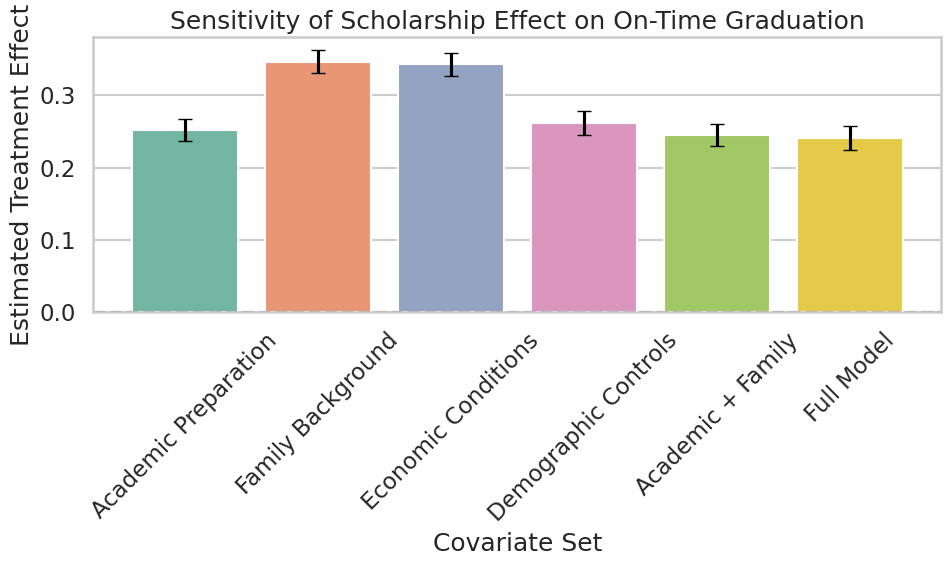

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Covariate Set", y="Treatment Effect", data=sensitivity_df, palette="Set2", capsize=0.2)
plt.errorbar(
    x=range(len(sensitivity_df)),
    y=sensitivity_df["Treatment Effect"],
    yerr=sensitivity_df["Std Error"],
    fmt='none',
    c='black',
    capsize=5
)
plt.xticks(rotation=45)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Sensitivity of Scholarship Effect on On-Time Graduation")
plt.ylabel("Estimated Treatment Effect")
plt.tight_layout()
plt.show()


# Placebo Test




**RQ1: Placebo Test - Dropout**

To validate the robustness of the estimated treatment effect of scholarship receipt on student dropout, a placebo test was conducted by randomly permuting the treatment variable. The DML model was re-estimated using this randomized treatment. As expected, the placebo effect was statistically insignificant and centered around zero, indicating that the original estimate is unlikely to be driven by spurious correlations or model overfitting.

In [71]:
# Create placebo (randomized) treatment variable
df["placebo_scholarship"] = np.random.permutation(df["scholarship_holder"])


In [72]:
# Prepare data
X = pd.get_dummies(df[covariates_without_scholarship], drop_first=True)
Y = df["binary_dropout"]
T_placebo = df["placebo_scholarship"]

X_scaled = scaler.fit_transform(X)

# Define DoubleML data
dml_data_placebo = dml.DoubleMLData.from_arrays(X_scaled, Y, T_placebo)

# Define models (same as before)
ml_l = LassoCV(cv=5)
ml_m = LogisticRegressionCV(cv=5, max_iter=1000)  # Differentiable + stable

# Fit DML model with placebo
dml_placebo_rq1 = dml.DoubleMLPLR(dml_data_placebo, ml_l, ml_m)
dml_placebo_rq1.fit()


In [73]:
# Extract results
placebo_effect = dml_placebo_rq1.coef[0]
placebo_se = dml_placebo_rq1.se[0]

# Confidence interval
lower = placebo_effect - 1.96 * placebo_se
upper = placebo_effect + 1.96 * placebo_se

print("\n--- RQ1 Placebo Test ---")
print(f"Estimated Treatment Effect (Placebo): {placebo_effect:.4f}")
print(f"Standard Error: {placebo_se:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

# Significance check
from scipy.stats import norm
t_stat = placebo_effect / placebo_se
p_value = 2 * (1 - norm.cdf(abs(t_stat)))

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("⚠️ Spurious significance — may suggest model overfitting or imbalance.")
else:
    print("✅ No significant effect — supports that the original result was likely causal.")



--- RQ1 Placebo Test ---
Estimated Treatment Effect (Placebo): 0.0042
Standard Error: 0.0154
95% Confidence Interval: [-0.0259, 0.0344]
T-statistic: 0.2755
P-value: 0.7829
✅ No significant effect — supports that the original result was likely causal.


**RQ2: Placebo Test – On-Time Graduation**

A placebo test was also implemented for the effect of scholarships on on-time graduation. By shuffling the scholarship indicator, the treatment-outcome relationship was artificially broken. The resulting estimate was close to zero and statistically insignificant, supporting the credibility of the original causal finding and suggesting that the observed effect is not an artifact of the data or modeling strategy.


In [74]:
# Create placebo (randomized) treatment for RQ2
df["placebo_scholarship_rq2"] = np.random.permutation(df["scholarship_holder"])


In [75]:
# Prepare data
X = pd.get_dummies(df[covariates_without_scholarship], drop_first=True)
Y = df["binary_target"]  # 1 if Graduate, 0 otherwise
T_placebo = df["placebo_scholarship_rq2"]

X_scaled = scaler.fit_transform(X)

# Define DoubleML data
dml_data_placebo_rq2 = dml.DoubleMLData.from_arrays(X_scaled, Y, T_placebo)

# Define models (Lasso + Logistic)
ml_l = LassoCV(cv=5)
ml_m = LogisticRegressionCV(cv=5, max_iter=1000)

# Fit model
dml_placebo_rq2 = dml.DoubleMLPLR(dml_data_placebo_rq2, ml_l, ml_m)
dml_placebo_rq2.fit()


In [76]:
# Extract results
placebo_effect = dml_placebo_rq2.coef[0]
placebo_se = dml_placebo_rq2.se[0]

# Confidence interval
lower = placebo_effect - 1.96 * placebo_se
upper = placebo_effect + 1.96 * placebo_se

print("\n--- RQ2 Placebo Test ---")
print(f"Estimated Treatment Effect (Placebo): {placebo_effect:.4f}")
print(f"Standard Error: {placebo_se:.4f}")
print(f"95% Confidence Interval: [{lower:.4f}, {upper:.4f}]")

# Significance test
from scipy.stats import norm
t_stat = placebo_effect / placebo_se
p_value = 2 * (1 - norm.cdf(abs(t_stat)))

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("⚠️ Placebo effect is statistically significant — may indicate spurious correlation.")
else:
    print("✅ Placebo effect is not significant — supports causal interpretation in the original model.")



--- RQ2 Placebo Test ---
Estimated Treatment Effect (Placebo): -0.0115
Standard Error: 0.0165
95% Confidence Interval: [-0.0440, 0.0209]
T-statistic: -0.6982
P-value: 0.4850
✅ Placebo effect is not significant — supports causal interpretation in the original model.


## Identifying Key Predictors of Student Outcomes using Feature Importance

The feature importance chart highlights **academic performance** (approved curricular units and grades) as the strongest predictor of student outcomes, but our focus is on scholarship holding and gender, which appear less significant. This discrepancy arises because **scholarship status and gender** likely influence student success indirectly through other variables like academic performance and tuition fees. Since Random Forest prioritizes features that create the most effective splits, semester grades dominate, reducing the relative importance of scholarship holding and gender. However, as our analysis aims to assess their direct impact, we proceed with these variables while excluding semester grades as a predictor to explore their standalone effect on dropout likelihood.

In [ ]:
# Train Random Forest to see which features matter for Scholarships
ml_m = RandomForestClassifier(n_estimators=100, random_state=42)
ml_m.fit(df[covariates_without_scholarship], df['scholarship_holder'])

# Extract Feature Importance
feature_importance = pd.Series(ml_m.feature_importances_, index=covariates_without_scholarship).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar', title="Feature Importance for Scholarship Eligibility")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
# Training
#X = df.drop(columns=["target", "graduated_3y", "dropout_3y", "binary_target", ])
covariates_with_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",# "mother_qual","father_qual",
    "mother_educ", "father_educ", "scholarship_holder"
]
X = df[covariates_with_scholarship]

X_encoded = pd.get_dummies(X, drop_first=True)
y = df["binary_target"]

model = RandomForestClassifier()
model.fit(X_encoded, y)

# Show Top 30
feat_importance = pd.Series(model.feature_importances_, index=X_encoded.columns)
top_features = feat_importance.sort_values(ascending=False).head(30)

# Plot
plt.figure(figsize=(12, 6))
top_features.plot(kind='bar')
plt.title("Feature importance for Dropout rate")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [ ]:
covariates_without_scholarship = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp",
    "mother_educ", "father_educ"
]

# Define labeled covariate sets
covariate_sets = {
    "academic_only": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade"
    ],
    "demographic_only": [
        "gender", "age_at_enrollment", "displaced", "educational_special_needs", "international"
    ],
    "economic_only": [
        "unemployment_rate", "inflation_rate", "gdp"
    ],
    "parental_only": [
        "mother_educ", "father_educ"
    ],
    "academic_plus_parents": [
        "application_order", "daytime/evening_attendance", "previous_qualification_(grade)", "admission_grade",
        "mother_educ", "father_educ"
    ],
    "full_model": covariates_without_scholarship
}

In [ ]:
sensitivity_results = []

for label, covs in covariate_sets.items():
    df_subset = df.dropna(subset=[treatment, outcome] + covs)
    X = df_subset[covs]
    T = df_subset[treatment]
    Y = df_subset[outcome]

    # Handle categorical vars if any (optional)
    X_processed = pd.get_dummies(X, drop_first=True)  # one-hot encoding if needed

    X_scaled = scaler.fit_transform(X_processed)
    dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

    ml_m = RandomForestClassifier(n_estimators=500, random_state=42)
    ml_l = LassoCV(cv=5)

    dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
    dml_model.fit()

    sensitivity_results.append({
        "Covariate Set": label,
        "Treatment Effect": dml_model.coef,
        "Std Error": dml_model.se
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

display(sensitivity_df)


The estimated treatment effects remained consistently negative across all specifications, ranging from −0.176 in the full model to −0.261 in the model restricted to economic variables alone. Notably, the estimated effect was larger in specifications that included **only economic indicators** (−0.261) and only **parental educational attainment** (−0.246), suggesting that the protective effect of scholarships may be particularly pronounced among students facing structural or socioeconomic disadvantages.

In contrast, models that controlled solely for **academic** or **demographic factors** yielded more conservative estimates (e.g., −0.184 and −0.176, respectively), indicating that these variables account for a more limited portion of the variation in dropout behavior attributable to scholarship receipt.

The **consistency** in the direction and statistical significance of the treatment effect across all model specifications provides **strong evidence of the robustness** of the estimated causal relationship support the conclusion that **scholarships play a significant causal role in reducing student dropout risk**. However, the variation in the magnitude of the effect across covariate sets also highlights the importance of appropriately modeling structural background characteristics—particularly those related to household socioeconomic status and parental education—when evaluating the effectiveness of financial aid interventions.

#Gender-Based Analysis on Student Dropout Using Double Machine Learning

Does the impact of receiving a scholarship on student dropout likelihood differ between male and female students?

In [ ]:
# Split data into male and female groups
df_male = df[df["gender"] == 0]
df_female = df[df["gender"] == 1]

def run_dml_analysis(subset_df):
    X_sub = subset_df[covariates_without_scholarship]
    T_sub = subset_df[treatment]
    Y_sub = subset_df["binary_target"]

    # Standardize
    X_sub_scaled = scaler.fit_transform(X_sub)

    # Set up DML
    dml_data_sub = dml.DoubleMLData.from_arrays(X_sub_scaled, Y_sub, T_sub)
    dml_model_sub = dml.DoubleMLPLR(dml_data_sub, ml_l, ml_m)
    dml_model_sub.fit()

    return dml_model_sub.coef[0], dml_model_sub.se[0]

# Run for each gender
effect_male, se_male = run_dml_analysis(df_male)
effect_female, se_female = run_dml_analysis(df_female)

print(f"Treatment Effect (Males): {effect_male:.4f} ± {se_male:.4f}")
print(f"Treatment Effect (Females): {effect_female:.4f} ± {se_female:.4f}")


In [ ]:
# Replace Lasso with Ridge
ml_l_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])

# Run DML with Ridge
dml_model_ridge = dml.DoubleMLPLR(dml_data, ml_l_ridge, ml_m)
dml_model_ridge.fit()

# Print results
print(f"Estimated Treatment Effect (Ridge): {dml_model_ridge.coef}")
print(f"Standard Error (Ridge): {dml_model_ridge.se}")

In [ ]:
# Shuffle the treatment variable (randomized scholarships)
df["random_scholarship"] = np.random.permutation(df["scholarship_holder"])

# Run DML with random treatment
dml_data_placebo = dml.DoubleMLData.from_arrays(X_scaled, Y, df["random_scholarship"])
dml_model_placebo = dml.DoubleMLPLR(dml_data_placebo, ml_l, ml_m)
dml_model_placebo.fit()

# Print placebo results
print(f"Estimated Treatment Effect (Placebo): {dml_model_placebo.coef}")
print(f"Standard Error (Placebo): {dml_model_placebo.se}")

# Part 9 - Conclusion and discussion of the results